# Plotting episode return during training

This notebook generates plots to evaluate the data generated during training

In [1]:
import numpy as np
import pandas as pd
import cmcrameri.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from os import path, listdir
from scipy.stats import normaltest, kruskal, mannwhitneyu
import matplotlib.patches as mpatches

from greenlight_gym.visualisations.utils import load_data

In [42]:
def arc_pen(x, ki:float):
    return np.arctan(x*ki)

def load_data(data_path, data_file):
    # load data from csv
    df = pd.read_csv(path.join(data_path, data_file))
    return df

def compute_profit_eps(df):
    # compute profit per episode
    N = (df[df['episode'] == 0]).shape[0]
    profits_per_episode = df[['Profits', 'episode']].groupby('episode').sum().reset_index()
    return profits_per_episode


def compute_constraints(df: pd.DataFrame, column: str, ki: float) -> pd.DataFrame:
    """
    Function that computes statistics for violations and profits per episode.
    This function takes in a DataFrame and the name of the column to be used for violations.

    Args:
    - df: the DataFrame
    - column: the name of the column to be used for violations

    Returns:
    - episode: the episode number
    - Profits: the total profits for the episode
    - CO2 Violation Time (%): the percentage of time with CO2 violations
    - CO2 Violation (ppm): the average magnitude of CO2 violations
    """
    # print(df)
    N = (df[df['episode'] == 0]).shape[0]
    # profits_per_episode = df[['Profits', 'episode']].groupby('episode').sum().reset_index()
    # CO2 violation time per episode, considering each row as 5 minutes

    df['penalty score'] = df[column].apply(arc_pen, args=(ki,))

    penalty_score = df.groupby('episode')['penalty score'].sum()
    # Combine the updated results into a summary DataFrame

    summary_df_updated = pd.DataFrame({
        f'Penalty scores': penalty_score,
        # f'{column} (abs)': avg_co2_violation_magnitude_updated,
    }).reset_index()

    return summary_df_updated

def aggregate_data(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Function that computes statistics for violations and profits per episode.
    This function takes in a DataFrame and the name of the column to be used for violations.

    Args:
    - df: the DataFrame
    - column: the name of the column to be used for violations

    Returns:
    - episode: the episode number
    - Profits: the total profits for the episode
    - CO2 Violation Time (%): the percentage of time with CO2 violations
    - CO2 Violation (ppm): the average magnitude of CO2 violations
    """
    # print(df)
    N = (df[df['episode'] == 0]).shape[0]
    profits_per_episode = df[['Profits', 'episode']].groupby('episode').sum().reset_index()
    # CO2 violation time per episode, considering each row as 5 minutes
    co2_violation_time_updated = df[df[column] > 0].groupby('episode').size()/N*100 # % of time with violation
    # Average magnitude of CO2 violations per episode, for positive violations only
    # avg_co2_violation_magnitude_updated = df[[column, 'episode']].groupby('episode')[column].sum()
    avg_co2_violation_magnitude_updated = df[df[column] > 0].groupby('episode')[column].mean()
    # Combine the updated results into a summary DataFrame
    summary_df_updated = pd.DataFrame({
        f'Time within boundary (%)': co2_violation_time_updated,
        f'{column} (abs)': avg_co2_violation_magnitude_updated,
    }).reset_index()


    # Create a DataFrame of all unique episodes to ensure all are represented
    all_episodes_df = pd.DataFrame(df['episode'].unique(), columns=['episode'])

    # Merge the summary of violations with the complete list of episodes
    # This ensures episodes with no violations are included, filling missing values appropriately
    full_summary_df = pd.merge(all_episodes_df, summary_df_updated, on='episode', how='left').fillna(0)
    # print(full_summary_df['coefficients'])
    full_summary_df = pd.merge(profits_per_episode, full_summary_df, on='episode', how='left').fillna(0)
    full_summary_df['Time within boundary (%)'] = 100- full_summary_df['Time within boundary (%)']
    return full_summary_df

def calculate_twb(dataframes, labels):
    twb_df = pd.DataFrame()
    twb_df_ci = pd.DataFrame()
    N = dataframes[0]['episode'].unique().shape[0]
    for j, df in enumerate(dataframes):
        vars = ['CO2 violation', 'Temperature violation', 'Humidity violation']
        violations = [aggregate_data(df, var) for var in vars]

        twb = np.array([violations[i]['Time within boundary (%)'].mean() for i in range(len(vars))])
        df_twb = pd.DataFrame({labels[j]: twb,}, index=vars)
        twb_df = pd.concat([twb_df, df_twb], axis=1)
        
        cis = [ci(violations[i]['Time within boundary (%)'].std(), N) for i in range(len(vars))]
        df_twb_ci = pd.DataFrame({labels[j]: cis,}, index=vars)
        twb_df_ci = pd.concat([twb_df_ci, df_twb_ci], axis=1)
    return twb_df.T, twb_df_ci.T


def calculate_tan(dataframes, labels, ks):
    twb_df = pd.DataFrame()
    twb_df_ci = pd.DataFrame()
    N = dataframes[0]['episode'].unique().shape[0]
    vars = ['CO2 violation', 'Temperature violation', 'Humidity violation']
    for j, df in enumerate(dataframes):
        violations = [compute_constraints(df, var, ks[i]) for i, var in enumerate(vars)]

        twb = np.array([violations[i]['Penalty scores'].mean() for i in range(len(vars))])
        df_twb = pd.DataFrame({labels[j]: twb,}, index=vars)
        twb_df = pd.concat([twb_df, df_twb], axis=1)

        cis = [ci(violations[i]['Penalty scores'].std(), N) for i in range(len(vars))]
        df_twb_ci = pd.DataFrame({labels[j]: cis,}, index=vars)
        twb_df_ci = pd.concat([twb_df_ci, df_twb_ci], axis=1)
    return twb_df.T, twb_df_ci.T

def ci(std, n, z=2.576):
    return z*std/np.sqrt(n)

def adjust_time(df):
    # compute max fruit harvest
    max_fruit_gr = 0.328*1e-6 # kg [DW] m-2 s-1
    delta_t = 300
    max_fruit_gr *= delta_t
    max_fruit_gr

    df['Time'] = df['Time'].map(lambda x: str(x)[:-6])
    df["Fruit harvest norm"] = df["Fruit harvest"] / max_fruit_gr
    df['Date'] = pd.to_datetime(df['Time'])
    df['TimeOfDay'] = df['Date'].dt.time
    return df

def plot_avg_day(df, variable, fig, ax, label, linestyle, color):
    time_step_means = df.groupby('TimeOfDay')[variable].mean().reset_index()
    # time_step_means = df.groupby('TimeOfDay')[variable].std().reset_index()

    # Convert 'TimeOfDay' to minutes past midnight for plotting
    time_step_means['MinutesPastMidnight'] = time_step_means['TimeOfDay'].apply(lambda t: t.hour + t.minute/60)

    # Plotting with the modified time format
    ax.plot(time_step_means['MinutesPastMidnight'], time_step_means[variable], linestyle=linestyle, linewidth=4, color=color, label=label)
    # ax.title('Average Temperature per Time Step Across All Runs')
    ax.set_xlabel('Hour of the day')
    ax.set_ylabel(variable)
    ax.set_xticks(np.arange(0, 25, 6))
    return fig, ax

def plot_avg_state(dataframes, labels, variables, colors):
    # nrows = len
    fig, axes = plt.subplots(1,len(variables), figsize =(16, 8), dpi=120)
    # colors = [cm.tokyoS(4+i) for i in range(len(dataframes))]
    for j, df in enumerate(dataframes):
        
        for i, ax in enumerate(axes):
            plot_avg_day(df, variables[i], fig, ax, labels[j], linestyle='-', color=colors[j])

    # Create the legend
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Adjust the layout to make space for the legend
    plt.subplots_adjust(right=0.8)

    # Show the plot
    # plt.show()
        

    fig.tight_layout()
    plt.show()


def generate_barplots(dataframes, xlabels, colors):
    fig, ax = plt.subplots(dpi=120)
    n = dataframes[0][0].shape[0]  # Assuming all dataframes have the same shape
    # print(n)
    # colors = [cm.tokyoS(4+i) for i in range(len(dataframes))]
    
    
    for i, dataframe in enumerate(dataframes):
        heights = []
        errors = []
        bar_width = 0.3

        for j, df in enumerate(dataframe):
            heights.append(df['Profits'].mean())
            errors.append(ci(df['Profits'].std(), n))
        print(len(heights), len(errors), len(xlabels))
        if i ==0:
            ax.bar(xlabels-bar_width/2, heights, width=bar_width, color=colors[i], edgecolor='black')
            ax.errorbar(xlabels-bar_width/2, heights, yerr=errors, capsize=5, linestyle='None', color='black', fmt='')
    
        else:
            ax.bar(xlabels+bar_width/2, heights, width=bar_width, color=colors[i], edgecolor='black')
            ax.errorbar(xlabels+bar_width/2, heights, yerr=errors, capsize=5, linestyle='None', color='black', fmt='')
    # print(heights, errors)

    ax.set_xlabel('Random seed')
    ax.set_ylabel(r'$r_{0:N}^{\mathrm{profit}}$')

    ax.set_xticks(xlabels)
    fig.tight_layout()
    fig.savefig('profits-per-seed-2.svg')
    plt.show()

# import matplotlib.pyplot as plt

def generate_grouped_bar_plot(twb_df, twb_df_ci, xlabels):
    co2color = cm.tokyoS(4)
    tcolor = cm.tokyoS(5)
    humcolor = cm.tokyoS(6)

    fig, ax = plt.subplots(dpi=120)

    index = np.arange(len(xlabels))

    bar_width = 0.2

    bars1 = ax.bar(index - bar_width, twb_df['CO2 violation'], bar_width, edgecolor='black', color=co2color, label=r'CO$_2$')
    ax.errorbar(index - bar_width, twb_df['CO2 violation'], yerr=twb_df_ci["CO2 violation"], capsize=5, linestyle='None', color='black', fmt='')

    bars2 = ax.bar(index, twb_df['Temperature violation'], bar_width, edgecolor='black', color=tcolor, label='Temperature')
    ax.errorbar(index, twb_df['Temperature violation'], yerr=twb_df_ci["Temperature violation"], capsize=5, linestyle='None', color='black', fmt='')

    bars3 = ax.bar(index + bar_width, twb_df['Humidity violation'], bar_width, edgecolor='black', color=humcolor, label='Humidity')
    ax.errorbar(index + bar_width, twb_df['Humidity violation'], yerr=twb_df_ci["Humidity violation"], capsize=5, linestyle='None', color='black', fmt='')

    ax.set_xticks(index)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Random seed')
    ax.set_ylabel('TWB (%)')
    ax.legend()
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    fig.tight_layout()
    fig.savefig('twb-seeds.svg')
    plt.show()


def generate_grouped_bar_plot2(twb_df1, twb_df_ci1, twb_df2, twb_df_ci2, xlabels):
    additive_color = cm.tokyoS(4)
    multiplicative_color = cm.tokyoS(6)

    fig, ax = plt.subplots(dpi=120)
    index = np.arange(len(xlabels))
    bar_width = 0.15
    
    # Controller 1
    bars1_1 = ax.bar(index - 2.5*bar_width, twb_df1['CO2 violation'], bar_width, edgecolor='black', color=additive_color, label=r'CO$_2$', hatch='//')
    bars1_1 = ax.bar(index - 2.5*bar_width, twb_df1['CO2 violation'], bar_width, edgecolor='black',color='none', label=r'CO$_2$')
    ax.errorbar(index - 2.5*bar_width, twb_df1['CO2 violation'], yerr=twb_df_ci1["CO2 violation"], capsize=5, linestyle='None', color='black', fmt='')

    bars1_2 = ax.bar(index - 0.5*bar_width, twb_df1['Temperature violation'], bar_width, edgecolor='black', color=additive_color, label='Temperature', hatch="\\\\")
    bars1_2 = ax.bar(index - 0.5*bar_width, twb_df1['Temperature violation'], bar_width, edgecolor='black', color='none', label='Temperature')
    ax.errorbar(index - 0.5*bar_width, twb_df1['Temperature violation'], yerr=twb_df_ci1["Temperature violation"], capsize=5, linestyle='None', color='black', fmt='')

    bars1_3 = ax.bar(index + 1.5*bar_width, twb_df1['Humidity violation'], bar_width, edgecolor='black', color=additive_color, label='Humidity (Controller 1)', hatch='xx')
    bars1_3 = ax.bar(index + 1.5*bar_width, twb_df1['Humidity violation'], bar_width, edgecolor='black', color='none', label='Humidity')
    ax.errorbar(index + 1.5*bar_width, twb_df1['Humidity violation'], yerr=twb_df_ci1["Humidity violation"], capsize=5, linestyle='None', color='black', fmt='')

    # Controller 2
    bars2_1 = ax.bar(index - 1.5*bar_width, twb_df2['CO2 violation'], bar_width, edgecolor='black', color=multiplicative_color, label=r'CO$_2$', hatch='//')
    bars2_1 = ax.bar(index - 1.5*bar_width, twb_df2['CO2 violation'], bar_width, edgecolor='black', color='none', label=r'CO$_2$')
    ax.errorbar(index - 1.5*bar_width, twb_df2['CO2 violation'], yerr=twb_df_ci2["CO2 violation"], capsize=5, linestyle='None', color='black', fmt='')

    bars2_2 = ax.bar(index + 0.5*bar_width, twb_df2['Temperature violation'], bar_width, edgecolor='black', color=multiplicative_color, label='Temperature (Controller 2)', hatch='\\\\')
    bars2_1 = ax.bar(index + 0.5*bar_width, twb_df2['Temperature violation'], bar_width, edgecolor='black', color='none', label='Temperature')
    ax.errorbar(index+ 0.5*bar_width, twb_df2['Temperature violation'], yerr=twb_df_ci2["Temperature violation"], capsize=5, linestyle='None', color='black', fmt='')

    bars2_3 = ax.bar(index + 2.5*bar_width, twb_df2['Humidity violation'], bar_width, edgecolor='black', color=multiplicative_color, label='Humidity (Controller 2)', hatch='xx')
    bars2_3 = ax.bar(index + 2.5*bar_width, twb_df2['Humidity violation'], bar_width, edgecolor='black', color='none', label='Humidity')
    ax.errorbar(index + 2.5*bar_width, twb_df2['Humidity violation'], yerr=twb_df_ci2["Humidity violation"], capsize=5, linestyle='None', color='black', fmt='')

    # Create custom patches for hatches
    hatch_CO2 = mpatches.Patch(facecolor='white', edgecolor='black', hatch='//', label=r'CO$_2$')
    hatch_Temperature = mpatches.Patch(facecolor='white', edgecolor='black', hatch='\\\\', label='Temperature')
    hatch_Humidity = mpatches.Patch(facecolor='white', edgecolor='black', hatch='xx', label='Humidity')

    ax.legend(handles=[hatch_CO2, hatch_Temperature, hatch_Humidity])

    ax.set_xticks(index)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Random seed')
    ax.set_ylabel('TWB (%)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    fig.tight_layout()
    fig.savefig('twb-seeds-comparison.svg', bbox_inches='tight')
    plt.show()




In [3]:
### Latex font in plots
plt.rcParams['font.serif'] = "cmr10"
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24

plt.rcParams['legend.fontsize'] = 24
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["axes.grid"] = False
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 4   # Default for all spines
# plt.rcParams['text.usetex'] = True
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.size'] = 6  # Thicker major x-ticks
plt.rcParams['xtick.major.width'] = 2  # Thicker major x-
plt.rcParams['ytick.major.size'] = 6  
plt.rcParams['ytick.major.width'] = 2 
plt.rc('axes', unicode_minus=False)


In [4]:
def format_ticks(x, pos):
    return f'{x * 1e-6}'


In [5]:
data_paths =  ['../data/benchmark/train/additive-0.99', '../data/benchmark/train/multiplicative-0.99']
data_file = 'rollout.csv'
dfs = [load_data(data_path, data_file) for data_path in data_paths]


In [30]:
def compute_stats(dfs, rolling_window_size=1):
    seeds_dfs = []
    for df in dfs:
        mean_seeds = df.groupby('global step')['train reward'].mean().rolling(rolling_window_size).mean()
        std_seeds = df.groupby('global step')['train reward'].std()

        # interpolate the missing values
        std_seeds = std_seeds.interpolate().rolling(rolling_window_size).mean()
        seeds_df = pd.DataFrame({'std': std_seeds, 'mean': mean_seeds})
        seeds_dfs.append(seeds_df)
    return seeds_dfs

def plot_learning_curve(seeds_dfs, labels, colors):

    fig, ax = plt.subplots(dpi=120)
    for i, seeds_df in enumerate(seeds_dfs):

        ax.plot(seeds_df.index, seeds_df['mean'], color=colors[i], label=labels[i])
        ax.fill_between(seeds_df.index, seeds_df['mean'] - seeds_df['std'], seeds_df['mean'] + seeds_df['std'], color=colors[i], alpha=0.3)

    ax.set_xlabel('Time steps (millions)')
    ax.set_ylabel('Average return')
    # ax.legend()
    ax.set_xscale('log')
    # ax.set_xticks(np.round(np.linspace(0, 4e7, 5), 0))
    ax.set_yticks(np.round(np.linspace(1200, 1650, 4), 0))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))

    formatter = FuncFormatter(format_ticks)
    #  plt.locator_params(axis='both', nbins=4) 
    # For x-axis
    ax.xaxis.set_major_formatter(formatter)
    fig.tight_layout()
    fig.savefig('convergence-seeds-xlog.svg')
    plt.show()

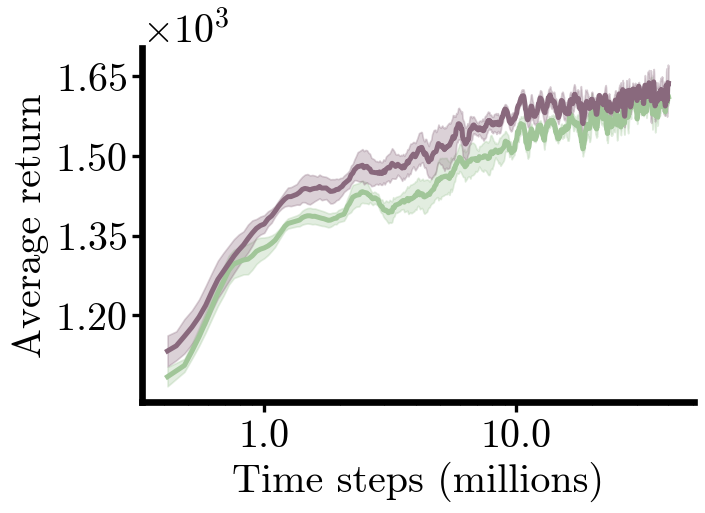

In [31]:
colors = [cm.tokyoS(4), cm.tokyoS(6)]
labels = ['Additive reward', 'Multiplicative reward']
seeds_dfs = compute_stats(dfs, rolling_window_size=10)
plot_learning_curve(seeds_dfs, labels, colors)


In [32]:
np.arange(501).shape

(501,)

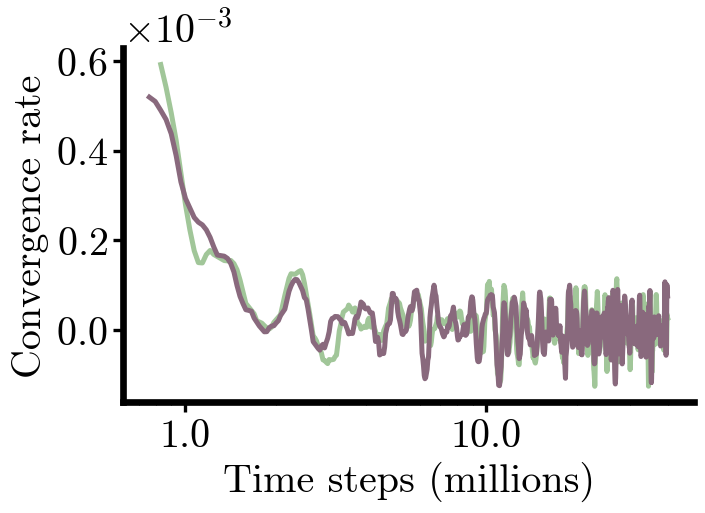

In [33]:
colors = [cm.tokyoS(4), cm.tokyoS(6)]
convergence_rate_1 = np.gradient(seeds_dfs[0]['mean'], seeds_dfs[0].index)
convergence_rate_2 = np.gradient(seeds_dfs[1]['mean'], seeds_dfs[1].index)

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size =10

smoothed_rate_1 = moving_average(convergence_rate_1, window_size=window_size)
smoothed_rate_2 = moving_average(convergence_rate_2, window_size=window_size)

fig, ax = plt.subplots(dpi=120)
ax.plot(seeds_dfs[0].index[window_size-1:], smoothed_rate_1,color=colors[0], label='Additive reward')
ax.plot(seeds_dfs[1].index[window_size-1:], smoothed_rate_2, color=colors[1],label='Multiplicative reward')

ax.set_xscale('log')
# ax.set_xticks(np.round(np.linspace(0, 4e7, 5), 0))
formatter = FuncFormatter(format_ticks)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Time steps (millions)')
ax.set_ylabel('Convergence rate')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
# ax.legend()

fig.tight_layout()
fig.savefig('convergence-rate-xlog.svg')

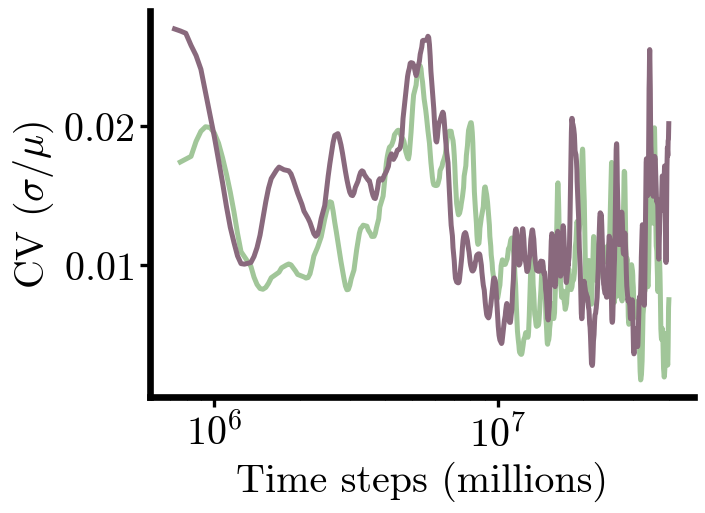

In [34]:
colors = [cm.tokyoS(4), cm.tokyoS(6)]
cv_loss_1 = seeds_dfs[0]['std'] /seeds_dfs[0]['mean']
cv_loss_2 = seeds_dfs[1]['std'] / seeds_dfs[1]['mean']

fig, ax = plt.subplots(dpi=120)

smoothened_cv_1 = moving_average(cv_loss_1, window_size=window_size)
smoothened_cv_2 = moving_average(cv_loss_2, window_size=window_size)

ax.plot(seeds_dfs[0].index[window_size-1:],smoothened_cv_1, color=colors[0], label='Additive reward')
ax.plot(seeds_dfs[1].index[window_size-1:], smoothened_cv_2, color=colors[1],  label='Multiplicative reward')

# ax.set_xticks(np.round(np.linspace(0, 4e7, 5), 0))
formatter = FuncFormatter(format_ticks)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Time steps (millions)')
ax.set_ylabel(r'CV $(\sigma/\mu)$')
ax.set_xscale('log')
fig.tight_layout()
fig.savefig('CV-xlog.svg')

# Visualising return distributions

In [48]:
import re

def extract_data(data_path, last):
    runnames = listdir(data_path)
    runnames = [runname for runname in runnames if '60' in runname]
    if last:
        print(runnames)
        runnames = [runname for runname in runnames if 'last' in runname]
    else:
        runnames = [runname for runname in runnames if 'best' in runname]

    runnames = sorted(runnames, key=lambda x: int(re.findall(r'\d+', x)[0]))
    print(runnames)
    # print(runnames)
    # sort run on the first integer in their name, use regex
    # print(runnames)
    
    dfs = [load_data(data_path, runname) for runname in runnames]
    dfs = [adjust_time(df) for df in dfs]
    return dfs, runnames

def compute_stats(dfs):
    returns = [df['Final return'].unique() for df in dfs]
    returns = [np.sort(ret) for ret in returns]
    means = np.mean(returns, axis=1)
    args = np.argsort(means)[::-1]
    quartile1, medians, quartile3 = np.percentile(returns, [25, 50, 75], axis=1)
    return quartile1[:], medians[:], quartile3[:], args[:], returns[:]
    # returns = [returns[i] for i in args]



In [49]:
multiplicative_path =  '../data/benchmark/train/multiplicative-0.99'
additive_path =  '../data/benchmark/train/additive-0.99'

multi_dfs, multi_runnames = extract_data(multiplicative_path, last=True)
additive_dfs, additive_runnames = extract_data(additive_path, last=True)

print(multi_runnames)

multi_profits_per_episode = [compute_profit_eps(df) for df in multi_dfs]
multi_twb_df, multi_twb_df_ci = calculate_twb(multi_dfs, multi_runnames)
additive_profits_per_episode = [compute_profit_eps(df) for df in additive_dfs]
additive_twb_df, additive_twb_df_ci = calculate_twb(additive_dfs, additive_runnames)


['elegant-carrier-2-60.csv', 'sweet-energy-9-60.csv', 'ancient-tie-fighter-4-60.csv', 'clean-pyramid-7-60.csv', 'rogue-podracer-3-60.csv']
[]
['vibrant-rain-15-60.csv', 'vague-breeze-17-60.csv', 'helpful-sky-20-60.csv', 'trim-dawn-16-60.csv', 'cerulean-dawn-19-60.csv']
[]
[]


IndexError: list index out of range

In [13]:
additive_stats = compute_stats(additive_dfs)
multi_stats = compute_stats(multi_dfs)
stats = [additive_stats, multi_stats]

In [27]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])
    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def plot_grouped_violin(stats, colors):
    fig, ax = plt.subplots(dpi=120)

    # Assuming stats is a list with two lists
    num_groups = len(stats[0][1])
    positions = np.arange(1, num_groups + 1)
    width = 0.3
    print(num_groups)
    for s, stat in enumerate(stats):
        quartile1, medians, quartile3, args, returns = stat

        # Offset the positions for each distribution
        pos = positions + width * (s - 0.5)

        parts = ax.violinplot(returns, positions=pos, widths=width,
                                showmeans=False, showmedians=False, showextrema=False)

        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[s])
            pc.set_edgecolor('black')
            pc.set_alpha(0.9)

        whiskers = np.array([
            adjacent_values(sorted_array, q1, q3)
            for sorted_array, q1, q3 in zip(returns, quartile1, quartile3)
        ])
        whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
        ax.scatter(pos, medians, marker='o', color='white', s=30, zorder=3)
        ax.vlines(pos, quartile1, quartile3, color='k', linestyle='-', lw=5)
        ax.vlines(pos, whiskers_min, whiskers_max, color='k', linestyle='-', lw=2)

    ax.set_xticks(positions)
    ax.set_xticklabels(positions)
    ax.set_yticks(np.round(np.linspace(1250, 2000, 4), 0))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
    ax.set_xlabel('Random seed')
    ax.set_ylabel('Episodic return')

    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[0]), 
                plt.Rectangle((0,0),1,1,fc=colors[1])],
                ['Additive reward', 'Multiplicative reward'], loc='upper right')

    fig.tight_layout()
    fig.savefig('episodic-return-violin.svg')
    plt.show()


5


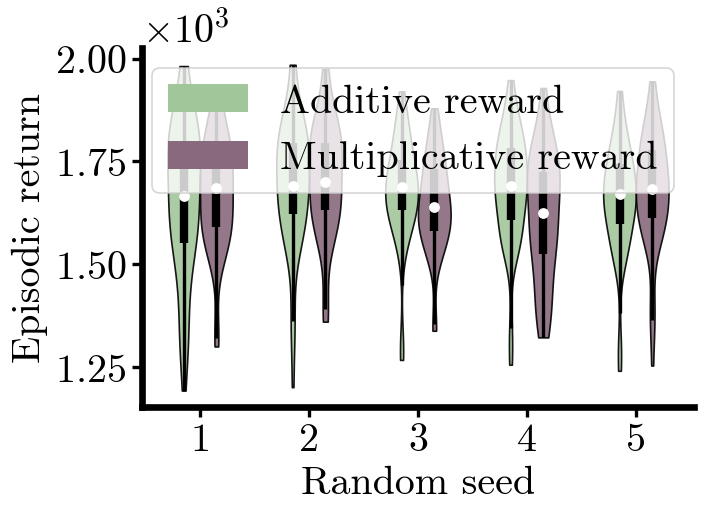

In [28]:
plot_grouped_violin(stats, colors)

### Test whether the distribution comes from normal distribution

If $p<0.05$ than we reject the null-hypothesis that the sample comes from a normal distribution.

In [16]:
def norm_test(returns):
    for ret in returns[:]:
        res = normaltest(ret)
        print(res.statistic, res.pvalue)

def display_stats(returns):
    for ret in returns:
        print(ret.mean(), np.median(ret), ret.std())

print("additive:")
norm_test(stats[0][-1])
print("multiplicative:")
norm_test(stats[1][-1])

additive:
2.992115754676987 0.22401150264797395
9.107312898535259 0.010528636490864295
17.953251136668072 0.00012632841567865956
10.792744816866236 0.00453299500731261
12.47744166699318 0.0019523513086389139
multiplicative:
3.7248336715243324 0.15529684947100303
2.6383297656147437 0.26735848442806454
3.4102669833168635 0.18174812269760185
2.886087762772213 0.23620767516799715
8.037964859678695 0.01797124263876408


In [17]:
print("additive:")
display_stats(stats[0][-1])
print("multiplicative:")
display_stats(stats[1][-1])

additive:
1660.230450439453 1666.687255859375 182.6134724068448
1696.4606180826822 1689.2705078125 153.41168241690963
1679.710274251302 1689.0743408203125 127.24131637033558
1686.80625 1689.2700805664062 136.27655173691755
1659.6511555989584 1670.9844970703125 132.13241717771604
multiplicative:
1674.567431640625 1684.4235229492188 136.0484569975294
1706.1334411621094 1699.4514770507812 138.12331561590193
1648.3936340332032 1638.581298828125 116.89155958573083
1620.8131917317708 1624.5220336914062 152.17274004666004
1678.3597330729167 1684.3125 137.87100819920033


In [18]:
import pandas as pd

def analyze_returns(returns, SEEDS):
    results = []

    for i, ret in enumerate(returns):
        for j, ret2 in enumerate(returns[i:]):
            j += i
            result = {
                'Seed 1': SEEDS[i],
                'Seed 2': SEEDS[j],
                'Mann-Whitney U': mannwhitneyu(ret, ret2).statistic,
                'p-value': mannwhitneyu(ret, ret2).pvalue
            }
            results.append(result)

    df_results = pd.DataFrame(results)
    return df_results


In [19]:
df = analyze_returns(stats[0][-1], additive_runnames)
df

,Seed 1,Seed 2,Mann-Whitney U,p-value
0,vibrant-rain-15-60.csv,vibrant-rain-15-60.csv,1800.0,1.000000
1,vibrant-rain-15-60.csv,trim-dawn-16-60.csv,1611.0,0.322483
2,vibrant-rain-15-60.csv,vague-breeze-17-60.csv,1730.0,0.715275
3,vibrant-rain-15-60.csv,cerulean-dawn-19-60.csv,1682.0,0.537423
4,vibrant-rain-15-60.csv,helpful-sky-20-60.csv,1871.0,0.711361
5,trim-dawn-16-60.csv,trim-dawn-16-60.csv,1800.0,1.000000
6,trim-dawn-16-60.csv,vague-breeze-17-60.csv,1950.0,0.432646
7,trim-dawn-16-60.csv,cerulean-dawn-19-60.csv,1893.0,0.627322
8,trim-dawn-16-60.csv,helpful-sky-20-60.csv,2130.0,0.083733
9,vague-breeze-17-60.csv,vague-breeze-17-60.csv,1800.0,1.000000


In [20]:
df = analyze_returns(stats[1][-1], multi_runnames)
df

,Seed 1,Seed 2,Mann-Whitney U,p-value
0,elegant-carrier-2-60.csv,elegant-carrier-2-60.csv,1800.0,1.000000
1,elegant-carrier-2-60.csv,rogue-podracer-3-60.csv,1533.0,0.161884
2,elegant-carrier-2-60.csv,ancient-tie-fighter-4-60.csv,2041.0,0.206842
3,elegant-carrier-2-60.csv,clean-pyramid-7-60.csv,2151.0,0.065820
4,elegant-carrier-2-60.csv,sweet-energy-9-60.csv,1737.0,0.742881
5,rogue-podracer-3-60.csv,rogue-podracer-3-60.csv,1800.0,1.000000
6,rogue-podracer-3-60.csv,ancient-tie-fighter-4-60.csv,2298.0,0.009023
7,rogue-podracer-3-60.csv,clean-pyramid-7-60.csv,2374.0,0.002612
8,rogue-podracer-3-60.csv,sweet-energy-9-60.csv,2014.0,0.262465
9,ancient-tie-fighter-4-60.csv,ancient-tie-fighter-4-60.csv,1800.0,1.000000


In [21]:
# kruskal(stats[0][-1])
kruskal(*stats[0][-1]), kruskal(*stats[1][-1]), 

(KruskalResult(statistic=3.3925359911407895, pvalue=0.4944054237278489),
 KruskalResult(statistic=12.864655592469603, pvalue=0.011956398678559674))

5 5 5
5 5 5


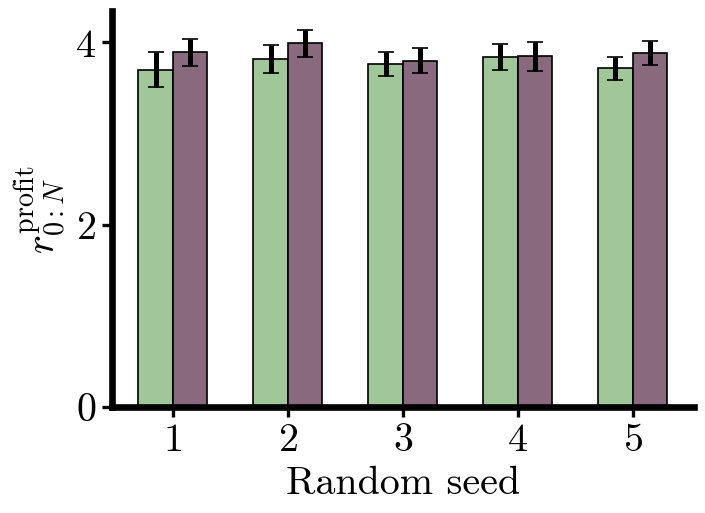

In [37]:
# colors= [cm.tokyoS(i) for i in range(4, 4+len(additive_runnames))]
colors = [cm.tokyoS(4), cm.tokyoS(6)]
# random_seeds = np.arange(len(runnames))
inds = np.arange(1, len(additive_runnames)+1)


generate_barplots([additive_profits_per_episode, multi_profits_per_episode], inds, colors)


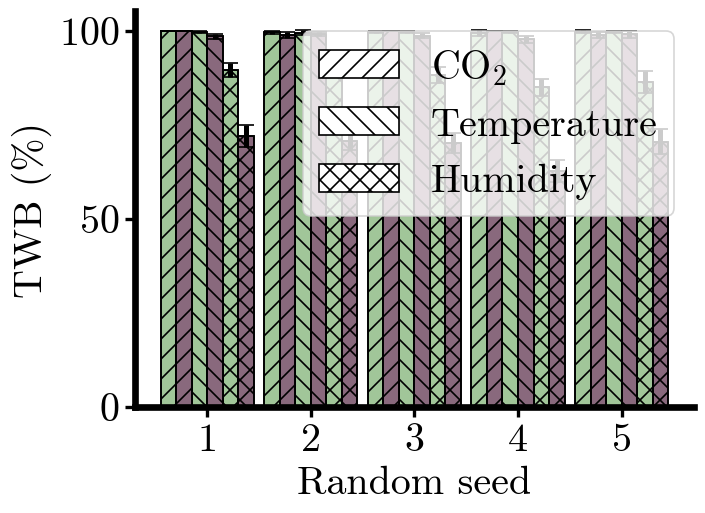

In [43]:

generate_grouped_bar_plot2(additive_twb_df, additive_twb_df_ci, multi_twb_df, multi_twb_df_ci, inds)

In [24]:
additive_twb_df.mean(), multi_twb_df.mean()


# , additive_twb_df_ci)


(CO2 violation            99.656250
 Temperature violation    99.623264
 Humidity violation       87.717477
 dtype: float64,
 CO2 violation            99.518866
 Temperature violation    98.605440
 Humidity violation       69.202199
 dtype: float64)

In [25]:
# additive_twb_df
# 